# Model inference I
Here we try to infer the effect of **geochemical factors** and **spatio-temporal components**, i.e., **[Biome, location, time]** on the microbial abundance of the species. 

For the purpose of our analysis, based on our clustering results, we have categorized species into five different groups. Our analysis summarize the findings in terms of the species representing these five groups and the effect of the factors on the species in these groups. 


### Geochemical component

In [1]:
## call python script to load data and column order
exec(open('data_file.py').read())
# load packages 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pltx
import seaborn as sns
import pystan
import pickle
import scipy.cluster.hierarchy as sch
import copy
import vb_stan as vbfun
import sub_fun as sf
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as ticker
import copy 
import random
import squarify
random.seed(123)
figfol = 'mem_plot/'

plt.rcParams.update(plt.rcParamsDefault)
params = {'legend.fontsize': 12,
          'font.weight': 'bold',
         'axes.labelsize': 12,
         'axes.titlesize':12,
         'axes.labelweight': 'bold',
         'xtick.labelsize':12,
          'axes.titleweight': 'bold',
         #'figure.figsize': (15,8),
          'figure.dpi': 300,
         'ytick.labelsize':12}
plt.rcParams.update(params)

%matplotlib inline
distinct_colp = ["maroon","brown","olive", "teal", "lightgreen", "red", "orange",\
 "yellow", "lime", "green", "cyan", "blue", "purple", "magenta",\
 "grey", "pink", "darkorange", "beige", "slategray", "lavender", "navy",\
     "cornflowerblue","olivedrab",'greenyellow','peru','darkslateblue']
# https://stackoverflow.com/questions/22408237/named-colors-in-matplotlib

/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


In [2]:
# Call the output from the fitted model:
fname_best = '66_model_nb_cvtest.pkl'
folname = 'MMSens/'
[holdout_mask, llpd, n_test, l,m_seed,sp_mean,\
 sp_var, h_prop, uid, nsample_o, Yte_fit, cv_test] = pickle.load(open(folname + fname_best, "rb"))

# -------------------------------------------------
# save model output 
fname_ot = folname + str(uid) + '_' + 'model_nb.pkl' 
#with open(fname_o, 'wb') as f:
#    pickle.dump(NB_vb, f)
with open(fname_ot, 'rb') as f:
    results = pickle.load(f)
    
sample_fname = folname + str(uid) + '_' + 'sample_model_nb_cvtest.pkl' 
with open(sample_fname, 'rb') as f:
    [Yte_sample,Yte_cv] = pickle.load(f)

parma_mean  = dict(vbfun.vb_extract_mean(results))

/mnt/home/amishra/jobs/microbiome/embeddings/vb_stan.py:57: RuntimeWarning: invalid value encountered in multiply
  params = OrderedDict([(name, np.nan * np.empty(shape)) for name, shape in param_shapes.items()])


In [3]:
## Extract annotation of the microbial species 
tax_name = pd.read_csv('species_tax.csv')
tax_name = tax_name.rename(columns={'Unnamed: 0': 'OTU'})
tax_name = tax_name[1:]
tax_name.insert(0, 'Id', tax_name['OTU'].str[3:])
tax_name.columns.values[1] = 'Label'
tax_name.to_csv('node_otu.csv', index = False) 
temx = tax_name.iloc[:,:8]
temx = temx.replace(np.nan,'')
species_name = []
# Add taxonomy identifier to the each of the species name 
for i in range(temx.shape[0]):
    a = temx.iloc[i,:].values
    for j in range(a.shape[0]-1,-1,-1):
        if len(a[j]) > 0:
            species_name.append(temx.columns[j][0].lower()+'_'+ a[j])
            break;           
species_name = np.array(species_name)  
tax_name['Name'] = species_name
# tax_name['ord_abu'] = np.linspace(10,1,tax_name.shape[0])[(-1*Y.mean(axis=0)).argsort()]
tax_name['Abundance'] = Y.sum(axis=0)
tax_name[['Id']] = tax_name[['Id']].values.astype(np.int64)
tax_name = tax_name.replace(np.nan,'Empty')
tem = pd.read_csv('species_tax_anot.amended.csv').iloc[:,[1,12]]
tax_name = tax_name.merge(tem,on = 'Label')
tax_name = tax_name.rename(columns={"Ecologically_relevant_classification_aggregated": "ECR"})

## Update the new annotation in the
i = 11    # index for ECR variable 
ind_var = tax_name.iloc[:,i].values
vals, counts = np.unique(ind_var, return_counts=True)
tem_ind1 = (-1*counts).argsort()
tem_val = vals[tem_ind1][range(np.min([np.sum(counts > 10),tem_ind1.shape[0]]))]
tmp = np.setdiff1d(np.unique(ind_var), tem_val)
import sub_fun as sf
tmp = sf.return_indices_of_a(tmp, ind_var)
ind_var[tmp] = "Other" 
tax_name.iloc[:,i] = ind_var

In [4]:
selected_species = list(np.unique(tax_name['ECR']))
species_col_dict = dict(zip(selected_species,distinct_colp[:len(selected_species)]))

## Order based on the cluster and order by 

In [5]:
tax_nameN = tax_name[['Label','ECR']]
tax_nameN['val'] = c_ord
tax_nameN.iloc[c_ord,2] = range(Y.shape[1])
## Add cluster index in the 
comunity2 = pickle.load(open('ERC_community.pkl', 'rb'))
tem = tax_nameN['Label'].map(comunity2) + 1
tax_nameN['Cluster'] = tem
tax_nameN = tax_nameN.sort_values(["Cluster", "val"], ascending = (True, False))
v_indexN = [0]+list(np.where(np.diff(tax_nameN.Cluster.values) ==1)[0]) + [Y.shape[1]]
c_ordN = np.array(tax_nameN.index)

/mnt/home/amishra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/mnt/home/amishra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

<font color=blue>**Based on the clustering results, we categorize species into five groups. Vertical lines in the plot below mark the category.** </font>

[523 400 307 112  36]


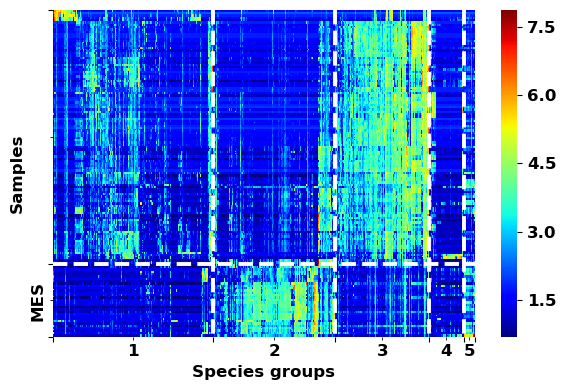

In [6]:
# v_index = [0, 320, 635 ,1000, 1290, Y.shape[1]]
v_index = [0, 322, 633, 1000, 1303, Y.shape[1]]
v_index = v_indexN

v_index_minor = [v_index[i] + 0.5*(v_index[i+1]- v_index[i]) for i  in range(len(v_index)-1)]
h_index = [0, 108, Y.shape[0]]
h_index_minor = [h_index[i] + 0.5*(h_index[i+1]- h_index[i]) for i  in range(len(h_index)-1)]
tem = np.log(Y[r_ord][:,c_ordN])
fig, ax = pltx.subplots(dpi = 100)
sns.heatmap(tem, cmap="jet", ax = ax, xticklabels = False, yticklabels = False)

# Formating the figure 
ax.vlines(v_index[1:-1], colors = 'white',\
          linestyles = 'dashed', ymin = 0, ymax = 139,\
              linewidths = 2.8)
ax.hlines(h_index[1:-1], colors = 'white',\
          linestyles = 'dashed', xmin = 0, xmax = 1378,\
              linewidths = 2.8)
ax.set_xticks(v_index)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.FixedLocator(v_index_minor))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(range(1,len(v_index))))
ax.set_yticks(h_index)
ax.yaxis.set_major_formatter(ticker.NullFormatter())
ax.yaxis.set_minor_locator(ticker.FixedLocator(h_index_minor))
ax.yaxis.set_minor_formatter(ticker.FixedFormatter([' ','MES']))
plt.setp( ax.yaxis.get_minorticklabels(), rotation=90, va='center' )
ax.set_xlabel('Species groups')
ax.set_ylabel('Samples')
fig.tight_layout()
fig.savefig(figfol + 'groupY.png')

print(np.diff(v_index))

<font color=blue>**Estimated contribution of the  biogeochemical covariates.** </font>


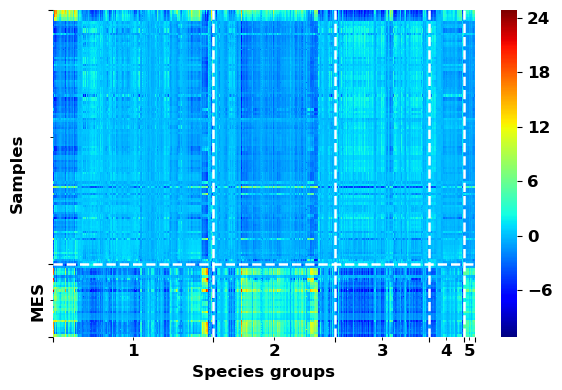

In [7]:
tem = np.matmul(X,parma_mean['C_geo'].transpose())
tem = tem[r_ord][:,c_ordN]

fig, ax = plt.subplots(dpi = 100)
#sns.heatmap(tem, cmap="jet", ax = ax, xticklabels = False, yticklabels = False)
sns.heatmap(tem, cmap="jet", ax = ax, xticklabels = False, yticklabels = False)
# Formating the figure 
ax.vlines(v_index[1:-1], colors = 'white',\
          linestyles = 'dashed', ymin = 0, ymax = 139,\
              linewidths = 1.8)
ax.hlines(h_index[1:-1], colors = 'white',\
          linestyles = 'dashed', xmin = 0, xmax = 1378,\
              linewidths = 1.8)
ax.set_xticks(v_index)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.FixedLocator(v_index_minor))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(range(1,len(v_index))))
ax.set_yticks(h_index)
ax.yaxis.set_major_formatter(ticker.NullFormatter())
ax.yaxis.set_minor_locator(ticker.FixedLocator(h_index_minor))
ax.yaxis.set_minor_formatter(ticker.FixedFormatter([' ','MES']))
plt.setp( ax.yaxis.get_minorticklabels(), rotation=90, va='center' )
ax.set_xlabel('Species groups')
ax.set_ylabel('Samples')
fig.tight_layout()
fig.savefig(figfol + 'groupGeo.png')

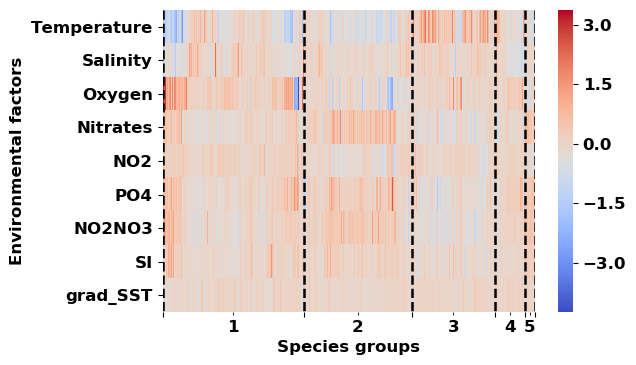

In [8]:
## Visualize the mean estimate of the coefficient matrix due to geochemical covariates 
tem = parma_mean['C_geo'].transpose()
label_var = ['Temperature', 'Salinity','Oxygen', 'Nitrates', 'NO2', 'PO4', 'NO2NO3', 'SI', 'grad_SST']

fig, ax = plt.subplots(dpi = 100)
#sns.heatmap(tem, cmap="jet", ax = ax, xticklabels = False, yticklabels = False)
sns.heatmap(tem[:,c_ordN], cmap="coolwarm", ax = ax, xticklabels = False, yticklabels = label_var)
ax.vlines(v_index, colors = 'black',\
          linestyles = 'dashed', ymin = 0, ymax = 139,\
              linewidths = 1.8)
    
ax.set_xlabel('Species groups')
ax.set_ylabel('Environmental factors')
ax.set_xticks(v_index)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.FixedLocator(v_index_minor))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(range(1,len(v_index))))
fig.savefig(figfol + 'geoEffect.png')

In [9]:
# Compute the average of the effect of covariates on each groups marked 
avg_effect = np.zeros((len(label_var), len(v_index) -1))
tem = parma_mean['C_geo'][c_ordN]
for i in range(len(v_index)-1):
     avg_effect[:,i] = np.mean(tem[v_index[i]:v_index[i+1]], axis =0) 
     
avg_effect = pd.DataFrame(avg_effect)
avg_effect.index = label_var
avg_effect.columns = range(1,6)
avg_effect

,1,2,3,4,5
Temperature,-0.357755,-0.379229,0.535746,0.005427,-0.308509
Salinity,-0.043407,-0.037092,0.074646,-0.236674,-0.061617
Oxygen,0.312296,-0.304904,0.040618,0.192356,-0.251224
Nitrates,-0.023371,0.416795,-0.250741,-0.121757,0.479977
NO2,0.115579,-0.089368,-0.032934,0.049442,-0.175992
PO4,0.121082,0.231628,-0.218303,0.123951,0.366397
NO2NO3,0.052202,0.274210,-0.201705,-0.019334,0.446918
SI,0.035359,0.085166,-0.113212,-0.067978,0.251205
grad_SST,-0.010210,-0.031077,-0.000370,0.036904,0.012999



<font color=blue>**Estimated Contribution of the Biome component** </font>

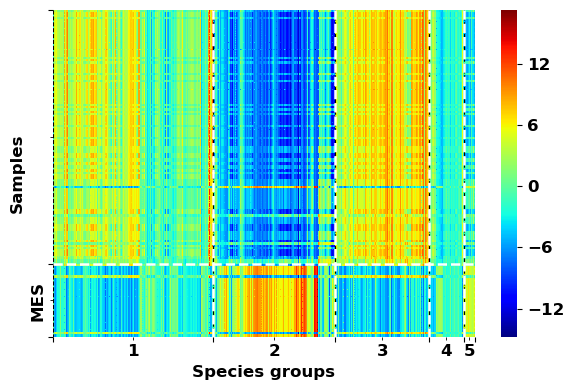

In [10]:
tem = np.matmul(B,np.matmul(parma_mean['A_b'],\
                            parma_mean['L_sp'].transpose()))
tem = tem[r_ord][:,c_ordN]
fig, ax = pltx.subplots(dpi = 100)
sns.heatmap(tem, cmap="jet", ax = ax, xticklabels = False, yticklabels = False)
ax.vlines(v_index, colors = 'black',\
          linestyles = 'dashed', ymin = 0, ymax = 139,\
              linewidths = .8)
# Formating the figure 
ax.vlines(v_index[1:-1], colors = 'white',\
          linestyles = 'dashed', ymin = 0, ymax = 139,\
              linewidths = 1.8)
ax.hlines(h_index[1:-1], colors = 'white',\
          linestyles = 'dashed', xmin = 0, xmax = 1378,\
              linewidths = 1.8)
ax.set_xticks(v_index)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.FixedLocator(v_index_minor))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(range(1,len(v_index))))
ax.set_yticks(h_index)
ax.yaxis.set_major_formatter(ticker.NullFormatter())
ax.yaxis.set_minor_locator(ticker.FixedLocator(h_index_minor))
ax.yaxis.set_minor_formatter(ticker.FixedFormatter([' ','MES']))
plt.setp( ax.yaxis.get_minorticklabels(), rotation=90, va='center' )
ax.set_xlabel('Species groups')
ax.set_ylabel('Samples')
fig.tight_layout()
fig.savefig(figfol + 'groupB.png')


In [11]:
# Compute the mean effect biome component on the species in each group 
label_var = np.unique(I[:,0])
tem =  np.matmul(parma_mean['A_b'],parma_mean['L_sp'].transpose()).transpose()
tem = tem[c_ordN]

avg_effect_b = np.zeros((len(label_var), len(v_index) -1))
for i in range(len(v_index)-1):
     avg_effect_b[:,i] = np.mean(tem[v_index[i]:v_index[i+1]], axis =0) 
     
avg_effect_b = pd.DataFrame(avg_effect_b)
avg_effect_b.index = label_var
avg_effect_b.columns = range(1,6)
avg_effect_b

,1,2,3,4,5
DCM,1.771349,-4.054757,5.767208,-0.925397,-0.753928
MES,-2.572720,5.654249,-3.651473,-1.441851,4.265417
MIX,0.422751,-0.000752,3.977362,-1.071215,1.185286
SRF,2.542291,-6.277950,6.045095,-0.960348,-4.463464


<font color=blue>**We jointly represent the effect of geochemical covariates and biome components on the five groups of the microbial species identified.** </font>



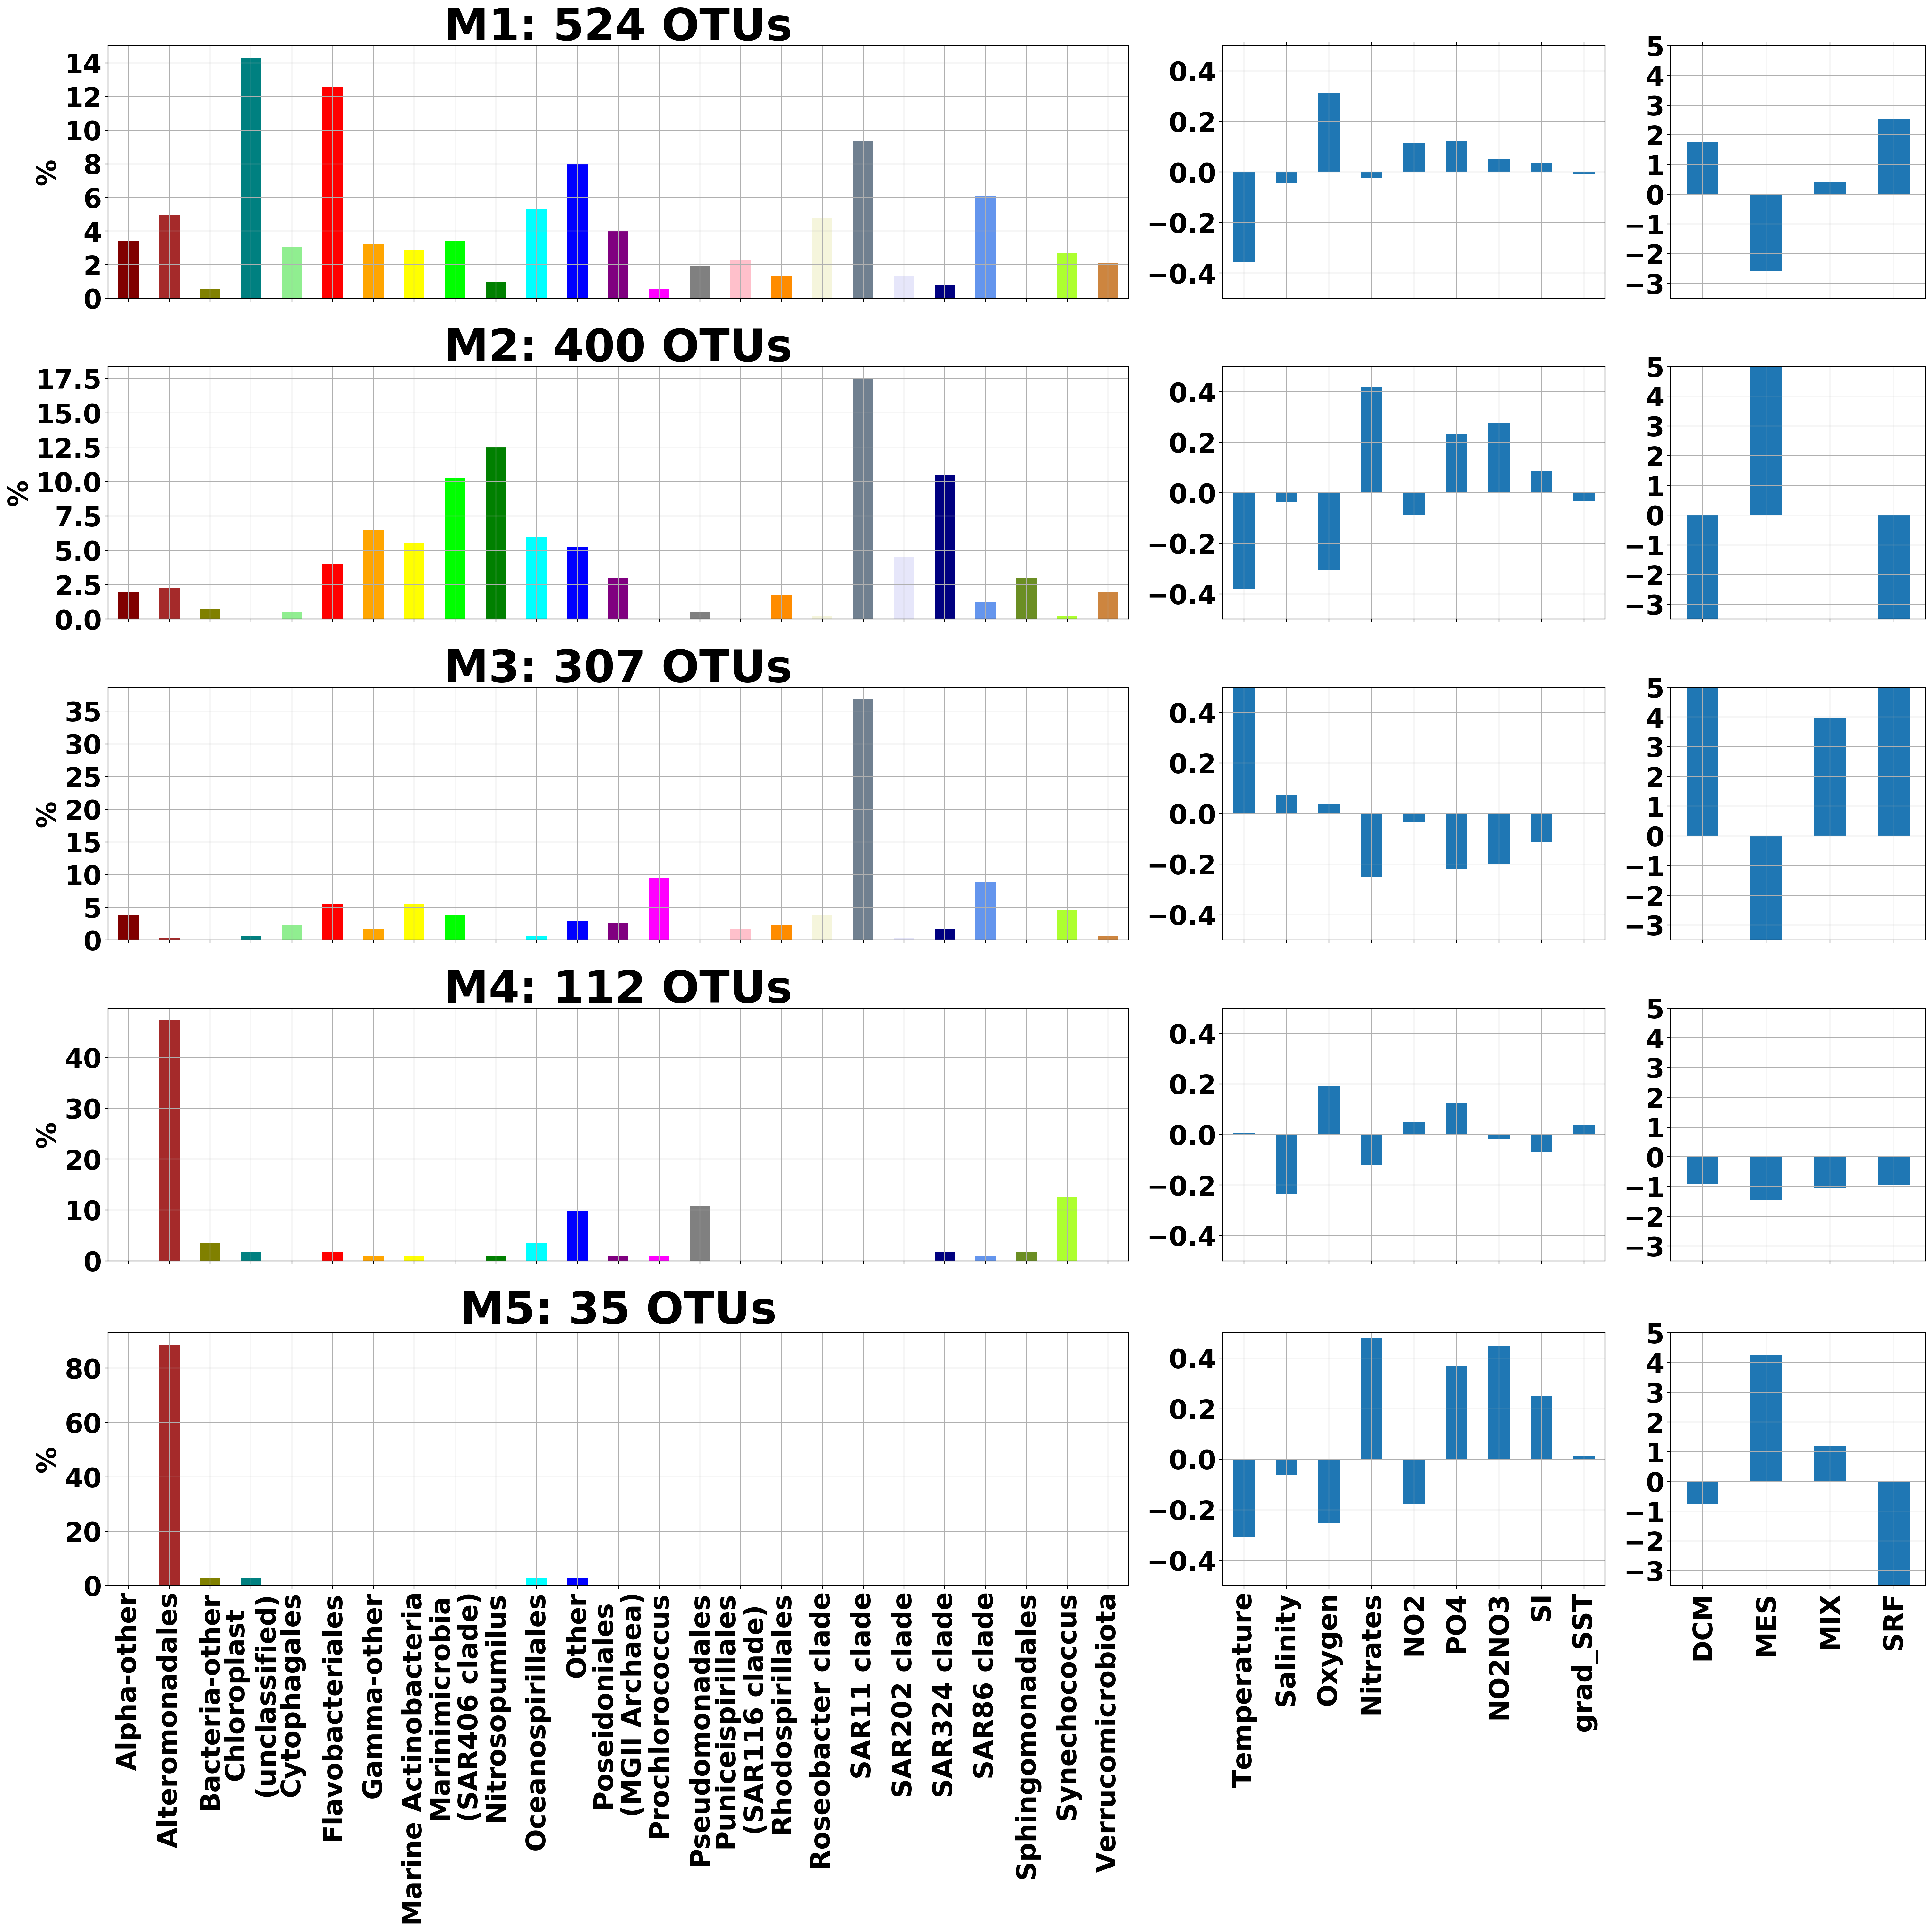

In [12]:
# np.random.seed(123)
# selected_species = list(np.unique(tax_name['ECR']))
# species_col_dict = dict(zip(selected_species,distinct_colp[:len(selected_species)]))

# tax_name2 = copy.copy(tax_name.iloc[c_ord,:])
# tem = np.array([None]*tax_name2.shape[0])
# for i in range(len(v_index)-1):
#     tem[v_index[i]:v_index[i+1]] = i+1
comunity2 = pickle.load(open('ERC_community.pkl', 'rb'))
comunity2

np.random.seed(123)
selected_species = list(np.unique(tax_name['ECR']))
species_col_dict = dict(zip(selected_species,distinct_colp[:len(selected_species)]))

tax_name2 = copy.copy(tax_name.iloc[c_ord,:])
tem = tax_name2['Label'].map(comunity2) + 1
tax_name2['Group'] = tem
tax_name3 = tax_name2[tem!=None]

tax_name4 = tax_name3[['Group','ECR','Abundance']].groupby(['Group','ECR'], as_index=False).agg(['count','sum'])
tax_name4 = tax_name4.reset_index()
tax_name4 = tax_name4.T.reset_index(drop=True).T
tax_name4.columns = ['Group','ECR','Count','Abundance']
tax_name4 = tax_name4.sort_values(by=['Group','Count'])


temp = tax_name4['Abundance'].values/(139.0*tax_name4['Count'].values)
tax_name4['MeanAbundance'] = np.around(temp.astype(np.float),1)
tax_name6 = tax_name4.pivot_table(values = 'MeanAbundance',index = 'ECR', columns = 'Group', aggfunc=np.sum, fill_value = 0)
tax_name5 = tax_name4.pivot_table(values = 'Count',index = 'ECR', columns = 'Group', aggfunc=np.sum, fill_value = 0)
tax_name5 = tax_name5.apply(lambda x: np.around(100.0*x/sum(x),2), axis=0)


col_bar = list(tax_name5.index.map(species_col_dict))

tax_name6.index = [i.replace(' (', '\n(') for i in tax_name6.index] 
tax_name5.index = [i.replace(' (', '\n(') for i in tax_name6.index] 

fig = plt.figure(constrained_layout=True, dpi = 200, figsize = (30,30))
G = plt.GridSpec(ncols=3, nrows=5, figure=fig, width_ratios=[2.0,0.75,0.5])
for i in range(1,6):
    fs = 30
    if i == 1:
        ay = fig.add_subplot(G[ i-1,0])
        tax_name5.plot(y=i, kind="bar", ax =ay, legend = False, color = col_bar, log = False, fontsize = fs)
        ay.set_ylabel('%', fontsize = fs)
        ay.grid()
        ay.set_title('M' + str(i) + ': ' + str(sum(tax_name3.Group.values == i)) + ' OTUs' , fontsize=50)
        ac = copy.copy(ay)
    else:
        ay = fig.add_subplot(G[i-1, 0])
        tax_name5.plot( y=i, kind="bar", ax =ay, legend = False, color = col_bar, fontsize = fs, sharex = ac)
        ay.set_title('M' + str(i) + ': ' + str(sum(tax_name3.Group.values == i)) + ' OTUs' , fontsize=50)
        ay.set_ylabel('%', fontsize = fs)
        ay.grid()
        
    
    fs = 30
    if i == 1:
        ay = fig.add_subplot(G[i-1,1])
        avg_effect.plot( y=i, kind="bar", ax =ay, legend = False, fontsize = fs)
        ay.set_ylim(-0.5,0.5)
        ay.grid()
        ay.xaxis.set_ticks_position('top')
        az = copy.copy(ay)
    else:
        ay = fig.add_subplot(G[i-1, 1])
        avg_effect.plot( y=i, kind="bar", ax =ay, legend = False, fontsize = fs, sharex = az)
        ay.set_ylim(-0.5,0.5)
        ay.grid()
        # ay.xaxis.set_ticks_position('top')
    
    if i == 1:
        ay = fig.add_subplot(G[ i-1,2])
        avg_effect_b.plot( y=i, kind="bar", ax =ay, legend = False, fontsize = fs)
        ab = copy.copy(ay)
        ay.set_ylim(-3.5,5)
        ay.grid()
        ay.xaxis.set_ticks_position('top')
    else:
        ay = fig.add_subplot(G[i-1,2])
        avg_effect_b.plot( y=i, kind="bar", ax =ay, legend = False, fontsize = fs, sharex = az)
        ay.set_ylim(-3.5,5)
        ay.grid()
        # ay.xaxis.set_ticks_position('top')
        
fig.savefig(figfol + 'groupJointBG5.eps', format = 'eps')
# fig.savefig(figfol + 'temp.png')